In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
data = pd.read_csv('final_dataset.csv')

In [11]:
# Cargar datos
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Seleccionar columnas relevantes
gold_columns = ['gold open', 'gold high', 'gold low', 'gold close', 'gold volume']
data_gold = data[gold_columns]

# Rellenar valores nulos con interpolación temporal
data_gold = data_gold.interpolate(method='time')

# Crear la variable objetivo desplazada
data_gold['gold_close_shifted'] = data_gold['gold close'].shift(-1)
data_gold.dropna(inplace=True)

# Dividir en características (X) y objetivo (y)
X = data_gold.drop(columns=['gold_close_shifted', 'gold close'])
y = data_gold['gold_close_shifted']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Predicción para el siguiente día
last_day_features = np.array([data_gold.iloc[-1][['gold open', 'gold high', 'gold low', 'gold volume']]])
last_day_scaled = scaler.transform(last_day_features)
next_day_prediction = model.predict(last_day_scaled)

print(f"Predicción del precio del oro para el próximo día: {next_day_prediction[0]:.2f}")


Mean Squared Error: 2.858678861196513
R^2 Score: 0.9942705287901573
Predicción del precio del oro para el próximo día: 253.41


/Users/queraltzamora/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Introduce la fecha objetivo (dentro de 5 años) para la que deseas predecir el precio del oro:

Predicción del precio del oro hasta la fecha introducida:
Fecha: 2024-10-23, Predicción: 186.40 USD
Fecha: 2024-10-24, Predicción: 182.81 USD
Fecha: 2024-10-25, Predicción: 180.86 USD


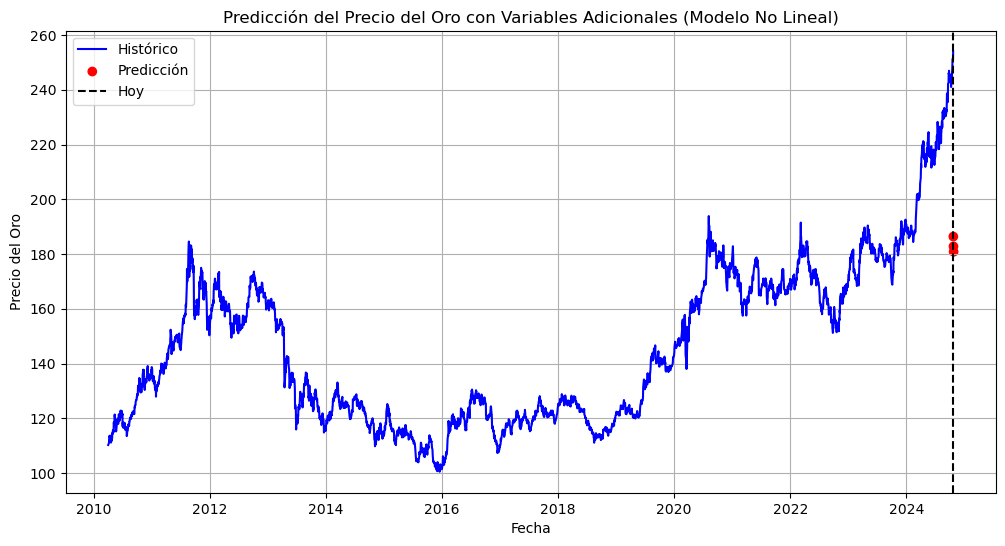

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Cargar datos
data = pd.read_csv('../financial_regression.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Generar variables simuladas (sin inflación)
np.random.seed(42)
if 'GDP' not in data.columns:
    data['GDP'] = np.linspace(20000, 23000, len(data))  # PIB creciente
if 'oil_price' not in data.columns:
    data['oil_price'] = np.random.uniform(50, 100, len(data))  # Precio del petróleo

# Seleccionar columnas relevantes (sin inflación)
gold_columns = ['gold open', 'gold high', 'gold low', 'gold close', 'gold volume', 'GDP', 'oil_price']
data_gold = data[gold_columns]

# Rellenar valores nulos con interpolación temporal
data_gold = data_gold.interpolate(method='time')

# Crear la variable objetivo desplazada
data_gold['gold_close_shifted'] = data_gold['gold close'].shift(-1)
data_gold.dropna(inplace=True)

# Dividir en características (X) y objetivo (y)
X = data_gold.drop(columns=['gold_close_shifted', 'gold close'])
y = data_gold['gold_close_shifted']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelo avanzado (Random Forest)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Solicitar fecha objetivo
print("\nIntroduce la fecha objetivo (dentro de 5 años) para la que deseas predecir el precio del oro:")
input_year = int(input("Año (YYYY): "))
input_month = int(input("Mes (MM): "))
input_day = int(input("Día (DD): "))

target_date = pd.Timestamp(year=input_year, month=input_month, day=input_day)
last_date = data_gold.index[-1]

# Validar que la fecha objetivo está en el futuro
if target_date <= last_date:
    print("La fecha debe ser posterior a la última fecha en los datos históricos.")
else:
    # Inicializar listas para gráficos
    historical_dates = data_gold.index
    historical_prices = data_gold['gold close']

    future_dates = []
    future_predictions = []

    # Iterar para predecir cada día hasta la fecha objetivo
    current_features = pd.DataFrame(data_gold.iloc[-1][['gold open', 'gold high', 'gold low', 'gold volume', 'GDP', 'oil_price']]).T
    current_features_scaled = scaler.transform(current_features)
    current_date = last_date

    while current_date < target_date:
        # Hacer predicción con el modelo Random Forest
        next_day_price = model_rf.predict(current_features_scaled)[0]
        
        # Guardar resultados para el gráfico
        current_date += pd.Timedelta(days=1)
        future_dates.append(current_date)
        future_predictions.append(next_day_price)

        # Crear datos simulados para el próximo día
        next_features = pd.DataFrame({
            'gold open': [next_day_price],
            'gold high': [next_day_price * 1.01],
            'gold low': [next_day_price * 0.99],
            'gold volume': [np.random.uniform(10000000, 20000000)],
            'GDP': [current_features.iloc[0]['GDP'] * 1.0001],  # PIB levemente creciente
            'oil_price': [np.random.uniform(50, 100)]  # Precio del petróleo aleatorio
        })
        
        # Escalar las características simuladas
        current_features_scaled = scaler.transform(next_features)
        current_features = next_features

    # Imprimir predicción para cada día
    print("\nPredicción del precio del oro hasta la fecha introducida:")
    for i in range(len(future_dates)):
        print(f"Fecha: {future_dates[i].date()}, Predicción: {future_predictions[i]:.2f} USD")

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    plt.plot(historical_dates, historical_prices, label='Histórico', color='blue')
    plt.scatter(future_dates, future_predictions, c=[
        'green' if pred > historical_prices.iloc[-1] else 'red'
        for pred in future_predictions
    ], label='Predicción')

    plt.title('Predicción del Precio del Oro con Variables Adicionales (Modelo No Lineal)')
    plt.xlabel('Fecha')
    plt.ylabel('Precio del Oro')
    plt.axvline(x=last_date, color='black', linestyle='--', label='Hoy')
    plt.legend()
    plt.grid()
    plt.show()



Enter the date for which you want to predict the S&P 500 closing price:

Predicted S&P 500 closing prices:
Date: 2024-10-23, Predicted closing price: 466.95 USD
Date: 2024-10-24, Predicted closing price: 434.03 USD
Date: 2024-10-25, Predicted closing price: 417.96 USD
Date: 2024-10-26, Predicted closing price: 409.02 USD
Date: 2024-10-27, Predicted closing price: 403.57 USD
Date: 2024-10-28, Predicted closing price: 397.34 USD
Date: 2024-10-29, Predicted closing price: 385.52 USD
Date: 2024-10-30, Predicted closing price: 381.39 USD
Date: 2024-10-31, Predicted closing price: 379.90 USD
Date: 2024-11-01, Predicted closing price: 379.53 USD
Date: 2024-11-02, Predicted closing price: 379.01 USD
Date: 2024-11-03, Predicted closing price: 378.52 USD
Date: 2024-11-04, Predicted closing price: 377.61 USD
Date: 2024-11-05, Predicted closing price: 377.98 USD
Date: 2024-11-06, Predicted closing price: 377.79 USD
Date: 2024-11-07, Predicted closing price: 377.80 USD
Date: 2024-11-08, Predicted 

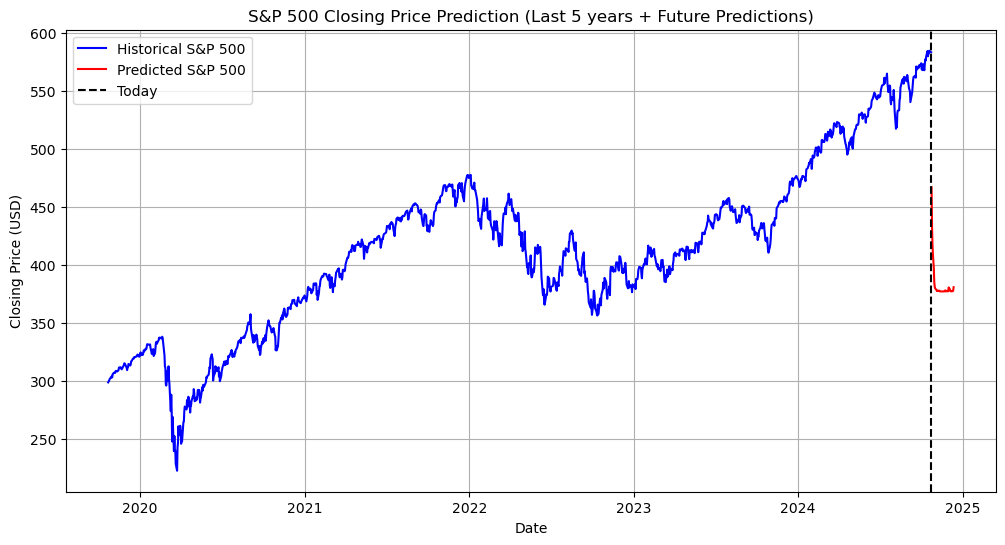

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load the dataset (replace 'your_dataset.csv' with your actual file path)
data = pd.read_csv('../financial_regression.csv', sep=",")

# Convert the 'date' column to datetime if it's not already
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Select the relevant features
features = ['sp500 open', 'sp500 high', 'sp500 low', 'sp500 volume', 'us_rates_%', 'CPI', 'usd_chf', 'eur_usd', 'GDP']

# Handle missing values if any (e.g., by forward filling or interpolating)
data = data.interpolate(method='time')
data.dropna(inplace=True)

# Create the target variable (next day's S&P 500 closing price)
data['sp500_close_shifted'] = data['sp500 close'].shift(-1)
data.dropna(inplace=True)

# Split into features (X) and target (y)
X = data[features]
y = data['sp500_close_shifted']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForestRegressor model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Get user input for the date they want to predict the S&P 500 closing price for
print("\nEnter the date for which you want to predict the S&P 500 closing price:")
input_year = int(input("Year (YYYY): "))
input_month = int(input("Month (MM): "))
input_day = int(input("Day (DD): "))

target_date = pd.Timestamp(year=input_year, month=input_month, day=input_day)

# Validate that the date is after the last date in the dataset
if target_date <= data.index[-1]:
    print("The target date must be after the latest date in the dataset.")
else:
    # Initialize lists for future predictions
    future_dates = []
    future_predictions = []

    # Start from the most recent data point
    current_features = data.iloc[-1][features]
    current_features = current_features.to_frame().T  # Convert to DataFrame
    current_features_scaled = scaler.transform(current_features)  # Reshape to (1, n_features)

    current_date = data.index[-1]

    while current_date < target_date:
        # Predict the next day's S&P 500 closing price
        next_day_prediction = model_rf.predict(current_features_scaled)[0]

        # Append prediction and date for future plotting
        future_dates.append(current_date + pd.Timedelta(days=1))
        future_predictions.append(next_day_prediction)

        # Simulate features for the next day (for simplicity, using predicted values)
        next_features = pd.DataFrame({
            'sp500 open': [next_day_prediction],
            'sp500 high': [next_day_prediction * 1.01],  # Assume high is 1% more than predicted close
            'sp500 low': [next_day_prediction * 0.99],   # Assume low is 1% less than predicted close
            'sp500 volume': [np.random.uniform(1000000, 2000000)],  # Random simulated volume
            'us_rates_%': [np.random.uniform(0, 5)],  # Random simulated interest rate
            'CPI': [np.random.uniform(1.5, 3.5)],  # Random simulated CPI
            'usd_chf': [np.random.uniform(0.9, 1.1)],  # Random simulated USD/CHF exchange rate
            'eur_usd': [np.random.uniform(1.0, 1.2)],  # Random simulated EUR/USD exchange rate
            'GDP': [current_features.iloc[0]['GDP'] * 1.0001]  # Assume slight GDP growth
        })

        # Update the current features for the next day
        current_features_scaled = scaler.transform(next_features)
        current_date += pd.Timedelta(days=1)

    # Print the predicted closing prices for the requested period
    print("\nPredicted S&P 500 closing prices:")
    for i in range(len(future_dates)):
        print(f"Date: {future_dates[i].date()}, Predicted closing price: {future_predictions[i]:.2f} USD")

    # Limit the historical data to the last 5 years
    start_date = data.index[-1] - pd.DateOffset(years=5)
    historical_data = data.loc[start_date:]

    # Plot the results
    plt.figure(figsize=(12, 6))

    # Plot the historical data (last 5 years)
    plt.plot(historical_data.index, historical_data['sp500 close'], label='Historical S&P 500', color='blue')

    # Plot the predicted data
    plt.plot(future_dates, future_predictions, color='red', label='Predicted S&P 500')

    # Customize the plot
    plt.title('S&P 500 Closing Price Prediction (Last 5 years + Future Predictions)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Today')  # Line indicating today
    plt.legend()
    plt.grid(True)
    plt.show()


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [15]:

# Load the dataset (replace 'your_dataset.csv' with your actual file path)
data = pd.read_csv('../financial_regression.csv', sep=",")

# Convert the 'date' column to datetime if it's not already
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

corr_matrix=data.corr()

# Select the relevant features (including open features)
features = ['sp500 open', 'sp500 high', 'sp500 low', 'sp500 volume', 'us_rates_%', 'CPI', 'usd_chf', 'eur_usd', 'GDP', 'gold close', 'oil close', 'nasdaq close', 'silver close']

# Handle missing values if any (e.g., by forward filling or interpolating)
data = data.interpolate(method='time')
data.dropna(inplace=True)


# Create the target variable (next day's S&P 500 closing price)
data['sp500_close_shifted'] = data['sp500 close'].shift(-1)
data.dropna(inplace=True)

corr_matrix = data.corr()
print(corr_matrix)

# Split into features (X) and target (y)
y = data['sp500_close_shifted']
X = data[features]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForestRegressor model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Calculate the correlation matrix between features

# Print the correlation matrix columns to check for available features
print("\nCorrelation Matrix Columns:")
print(corr_matrix.columns)

# Get user input for the date they want to predict the S&P 500 closing price for
print("\nEnter the date for which you want to predict the S&P 500 closing price:")
input_year = int(input("Year (YYYY): "))
input_month = int(input("Month (MM): "))
input_day = int(input("Day (DD): "))

target_date = pd.Timestamp(year=input_year, month=input_month, day=input_day)

# Validate that the target date is after the latest date in the dataset
if target_date <= data.index[-1]:
    print("The target date must be after the latest date in the dataset.")
else:
    # Initialize lists for future predictions
    future_dates = []
    future_predictions = []

    # Get the most recent data point (start prediction from here)
    current_features = data.iloc[-1][features]
    current_features = current_features.to_frame().T  # Convert to DataFrame

    current_date = data.index[-1]

    while current_date < target_date:
        # Predict the next day's S&P 500 closing price
        next_day_prediction = model_rf.predict(scaler.transform(current_features))[0]

        # Append prediction and date for future plotting
        future_dates.append(current_date + pd.Timedelta(days=1))
        future_predictions.append(next_day_prediction)

        # Predict next features based on correlation
        next_features = pd.DataFrame(columns=features)

        for feature in features:
            # Get the correlation for the current feature with the target (sp500 close)
            
            corr_with_sp500 = corr_matrix[feature]['sp500_close_shifted']
            
            # If the correlation with 'sp500 close' is high, use the value based on sp500 close prediction

            if abs(corr_with_sp500) > 0.5:  # Arbitrary threshold for strong correlation
                next_features[feature] = [next_day_prediction * (1 + corr_with_sp500)]  # Adjust based on correlation
            else:
                # For weakly correlated features, generate random values within a reasonable range
                if feature == 'us_rates_%':
                    # Interest rates generally vary between 0% and 5%, but can be influenced by broader market conditions
                    next_features[feature] = [np.random.uniform(0, 5)]
                elif feature == 'CPI':
                    # CPI can vary, but should stay within a range typical of inflation (e.g., 1.5% to 3.5%)
                    next_features[feature] = [np.random.uniform(1.5, 3.5)]
                elif feature == 'gold close':
                    # Gold tends to follow the S&P 500 in some ways, but with more volatility (e.g., adjust by 80% of the prediction)
                    next_features[feature] = [next_day_prediction * 0.8]  # Assume gold follows a similar pattern
                elif feature == 'sp500 volume':
                    # Volume can vary significantly, but let's use a reasonable range (e.g., 1M to 2M)
                    next_features[feature] = [np.random.uniform(1000000, 2000000)]  
                elif feature == 'usd_chf' or feature == 'eur_usd':
                    # Exchange rates can be more volatile but generally fluctuate within a range
                    next_features[feature] = [np.random.uniform(0.9, 1.2)]  # Simulating reasonable fluctuation for USD/CHF, EUR/USD
                else:
                    # For the remaining features, assume a slight increase or decrease
                    next_features[feature] = [np.random.uniform(0.9, 1.1) * next_day_prediction]  # Slightly adjust based on trend
         
        # Update the current features for the next day
        current_features = next_features
        current_date += pd.Timedelta(days=1)

    # Print the predicted closing prices for the requested period
    print("\nPredicted S&P 500 closing prices:")
    for i in range(len(future_dates)):
        print(f"Date: {future_dates[i].date()}, Predicted closing price: {future_predictions[i]:.2f} USD")

    # Limit the historical data to the last 5 years
    start_date = data.index[-1] - pd.DateOffset(years=5)
    historical_data = data.loc[start_date:]

    # Plot the results
    plt.figure(figsize=(12, 6))

    # Plot the historical data (last 5 years)
    plt.plot(historical_data.index, historical_data['sp500 close'], label='Historical S&P 500', color='blue')

    # Plot the predicted data
    plt.scatter(future_dates, future_predictions, color='red', label='Predicted S&P 500', marker='x')

    # Customize the plot
    plt.title('S&P 500 Closing Price Prediction (Last 5 years + Future Predictions)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Today')  # Line indicating today
    plt.legend()
    plt.grid(True)
    plt.show()


                     sp500 open  sp500 high  sp500 low  sp500 close  \
sp500 open             1.000000    0.999915   0.999888     0.999811   
sp500 high             0.999915    1.000000   0.999820     0.999880   
sp500 low              0.999888    0.999820   1.000000     0.999896   
sp500 close            0.999811    0.999880   0.999896     1.000000   
sp500 volume          -0.505498   -0.501874  -0.511008    -0.507163   
sp500 high-low         0.510222    0.517142   0.500831     0.508218   
nasdaq open            0.991554    0.991590   0.991347     0.991402   
nasdaq high            0.991480    0.991649   0.991291     0.991460   
nasdaq low             0.991506    0.991566   0.991482     0.991532   
nasdaq close           0.991378    0.991554   0.991350     0.991568   
nasdaq volume         -0.030482   -0.025918  -0.037864    -0.032695   
nasdaq high-low        0.696642    0.701546   0.689328     0.694675   
us_rates_%             0.691204    0.690716   0.692116     0.691431   
CPI   

ValueError: invalid literal for int() with base 10: ''